<a href="https://colab.research.google.com/github/Jane0731/Homework/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A_W11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

from google.colab import files
files.upload()  # This will allow you to upload your kaggle.json

import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c stock-market-prediction-and-sentimental-analysis

!unzip stock-market-prediction-and-sentimental-analysis.zip

Saving kaggle.json to kaggle.json
 65% 4.00M/6.17M [00:01<00:00, 4.47MB/s]
100% 6.17M/6.17M [00:01<00:00, 4.67MB/s]
Archive:  stock-market-prediction-and-sentimental-analysis.zip
  inflating: Combined_News_DJIA(train).csv  
  inflating: DJIA_table(train).csv   
  inflating: RedditNews(train).csv   
  inflating: TEST_Redit_news.csv     
  inflating: Test_Combined_News.csv  
  inflating: Test_DJIA_Table.csv     
  inflating: sample_submission.csv   


In [7]:
import pandas as pd

# 加載數據
news_data = pd.read_csv("RedditNews(train).csv")  # 包含日期和新聞標題
stock_data = pd.read_csv("DJIA_table(train).csv")  # 包含日期和股價數據

print(news_data.head())
print(stock_data.head())

         Date                                               News
0  2016-07-01  A 117-year-old woman in Mexico City finally re...
1  2016-07-01   IMF chief backs Athens as permanent Olympic host
2  2016-07-01  The president of France says if Brexit won, so...
3  2016-07-01  British Man Who Must Give Police 24 Hours' Not...
4  2016-07-01  100+ Nobel laureates urge Greenpeace to stop o...
         Date         Open         High          Low        Close    Volume  \
0  31-12-2015  17590.66016  17590.66016  17421.16016  17425.02930  93690000   
1  30-12-2015  17711.93945  17714.13086  17588.86914  17603.86914  59760000   
2  29-12-2015  17547.36914  17750.01953  17547.36914  17720.98047  69860000   
3  28-12-2015  17535.66016  17536.90039  17437.33984  17528.26953  59770000   
4  24-12-2015  17593.25977  17606.33984  17543.94922  17552.16992  40350000   

     Adj Close  
0  17425.02930  
1  17603.86914  
2  17720.98047  
3  17528.26953  
4  17552.16992  


In [9]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from tqdm import tqdm
import torch

# 啟用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加載 DistilBERT 模型和分詞器
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)

# 批量處理新聞數據
def analyze_sentiments_batch(headlines, batch_size=32):
    sentiments = []
    for i in tqdm(range(0, len(headlines), batch_size)):  # 使用進度條顯示
        batch = headlines[i:i+batch_size]
        inputs = tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_sentiments = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        sentiments.extend(batch_sentiments)
    return sentiments


# 分析新聞情緒
news_data['Sentiment'] = analyze_sentiments_batch(news_data['News'].tolist(), batch_size=16)
news_data

Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 4601/4601 [02:21<00:00, 32.48it/s]


,Date,News,Sentiment
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,1
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,1
2,2016-07-01,"The president of France says if Brexit won, so...",1
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,1
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,1
...,...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...,1
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...,1
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...,1
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ...",1


In [10]:
# 計算每日情緒分佈
sentiment_distribution = news_data.groupby("Date")["Sentiment"].value_counts(normalize=True).unstack(fill_value=0)

# 重命名列（0: Negative, 1: Neutral, 2: Positive）
sentiment_distribution.columns = ["Negative", "Neutral", "Positive"]
sentiment_distribution.reset_index(inplace=True)

# 查看每日情緒分佈
print(sentiment_distribution.head())

         Date  Negative  Neutral  Positive
0  2008-06-08      0.04     0.96       0.0
1  2008-06-09      0.08     0.92       0.0
2  2008-06-10      0.00     1.00       0.0
3  2008-06-11      0.12     0.88       0.0
4  2008-06-12      0.04     0.96       0.0


In [19]:
news_data['Date'] = pd.to_datetime(news_data['Date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [22]:
merged_data = pd.merge(stock_data, sentiment_distribution, on="Date", how="inner")
merged_data

,Date,Open,High,Low,Close,Volume,Adj Close,Negative,Neutral,Positive
0,2015-12-31,17590.66016,17590.66016,17421.16016,17425.02930,93690000,17425.02930,0.16,0.84,0.0
1,2015-12-30,17711.93945,17714.13086,17588.86914,17603.86914,59760000,17603.86914,0.28,0.72,0.0
2,2015-12-29,17547.36914,17750.01953,17547.36914,17720.98047,69860000,17720.98047,0.20,0.80,0.0
3,2015-12-28,17535.66016,17536.90039,17437.33984,17528.26953,59770000,17528.26953,0.24,0.76,0.0
4,2015-12-24,17593.25977,17606.33984,17543.94922,17552.16992,40350000,17552.16992,0.28,0.72,0.0
...,...,...,...,...,...,...,...,...,...,...
1858,2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,11615.92969,0.04,0.96,0.0
1859,2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,11532.95996,0.08,0.92,0.0
1860,2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973,0.08,0.92,0.0
1861,2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961,0.00,1.00,0.0


In [23]:
from sklearn.preprocessing import StandardScaler
import torch

# 股票數據特徵
stock_features = merged_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = StandardScaler()
stock_features = scaler.fit_transform(stock_features)

# 新聞情緒特徵
sentiment_features = merged_data[['Negative', 'Neutral', 'Positive']].values

# 漲跌標籤（1: 漲, 0: 跌）
labels = (merged_data['Close'].shift(-1) > merged_data['Close']).astype(int).values[:-1]

# 去掉最後一行，因為沒有標籤
stock_features = stock_features[:-1]
sentiment_features = sentiment_features[:-1]

# 轉為 Tensor
stock_features = torch.tensor(stock_features, dtype=torch.float32)
sentiment_features = torch.tensor(sentiment_features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)


In [24]:
import torch
import torch.nn as nn

class StockModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StockModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.fc(x)

# 股票數據模型
stock_model = StockModel(input_dim=5, hidden_dim=64, output_dim=2)  # 5 個股價特徵，2 類別

In [25]:
class LateFusionModel(nn.Module):
    def __init__(self, stock_model, sentiment_weight=0.5):
        super(LateFusionModel, self).__init__()
        self.stock_model = stock_model
        self.sentiment_weight = sentiment_weight

    def forward(self, stock_features, sentiment_probs):
        # 股票模型預測
        stock_probs = self.stock_model(stock_features)
        # 提取新聞情緒的 Positive 和 Negative 概率，忽略 Neutral
        sentiment_probs = sentiment_probs[:, [0, 2]]  # 第 0 列是 Negative，第 2 列是 Positive

        # 融合預測
        final_probs = stock_probs * (1 - self.sentiment_weight) + sentiment_probs * self.sentiment_weight
        return final_probs

In [26]:
from sklearn.model_selection import train_test_split

# 分割股票數據
train_stock, val_stock, train_sentiments, val_sentiments, train_labels, val_labels = train_test_split(
    stock_features, sentiment_features, labels, test_size=0.2, random_state=42)

# 將數據轉為 Tensor
train_stock = torch.tensor(train_stock, dtype=torch.float32)
val_stock = torch.tensor(val_stock, dtype=torch.float32)
train_sentiment = torch.tensor(train_sentiments, dtype=torch.float32)
val_sentiment = torch.tensor(val_sentiments, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)


<ipython-input-26-4283fc0c2616>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_stock = torch.tensor(train_stock, dtype=torch.float32)
<ipython-input-26-4283fc0c2616>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_stock = torch.tensor(val_stock, dtype=torch.float32)
<ipython-input-26-4283fc0c2616>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_sentiment = torch.tensor(train_sentiments, dtype=torch.float32)
<ipython-input-26-4283fc0c2616>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourc

In [27]:
def train_model(model, stock_inputs, sentiment_inputs, labels, optimizer, criterion, epochs=500):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # 模型預測
        outputs = model(stock_inputs, sentiment_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

In [28]:
# 初始化晚期融合模型
fusion_model = LateFusionModel(stock_model, sentiment_weight=0.5)

# 定義優化器和損失函數
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Epoch 1/1000, Loss: 0.5063, Val Accuracy: 0.9571
Epoch 2/1000, Loss: 0.5063, Val Accuracy: 0.9544
Epoch 3/1000, Loss: 0.5062, Val Accuracy: 0.9544
Epoch 4/1000, Loss: 0.5062, Val Accuracy: 0.9544
Epoch 5/1000, Loss: 0.5062, Val Accuracy: 0.9544
Epoch 6/1000, Loss: 0.5062, Val Accuracy: 0.9544
Epoch 7/1000, Loss: 0.5062, Val Accuracy: 0.9544
Epoch 8/1000, Loss: 0.5062, Val Accuracy: 0.9571
Epoch 9/1000, Loss: 0.5061, Val Accuracy: 0.9544
Epoch 10/1000, Loss: 0.5061, Val Accuracy: 0.9571
Epoch 11/1000, Loss: 0.5061, Val Accuracy: 0.9544
Epoch 12/1000, Loss: 0.5061, Val Accuracy: 0.9571
Epoch 13/1000, Loss: 0.5061, Val Accuracy: 0.9544
Epoch 14/1000, Loss: 0.5061, Val Accuracy: 0.9544
Epoch 15/1000, Loss: 0.5061, Val Accuracy: 0.9544
Epoch 16/1000, Loss: 0.5060, Val Accuracy: 0.9544
Epoch 17/1000, Loss: 0.5060, Val Accuracy: 0.9544
Epoch 18/1000, Loss: 0.5060, Val Accuracy: 0.9544
Epoch 19/1000, Loss: 0.5060, Val Accuracy: 0.9544
Epoch 20/1000, Loss: 0.5060, Val Accuracy: 0.9544
Epoch 21/

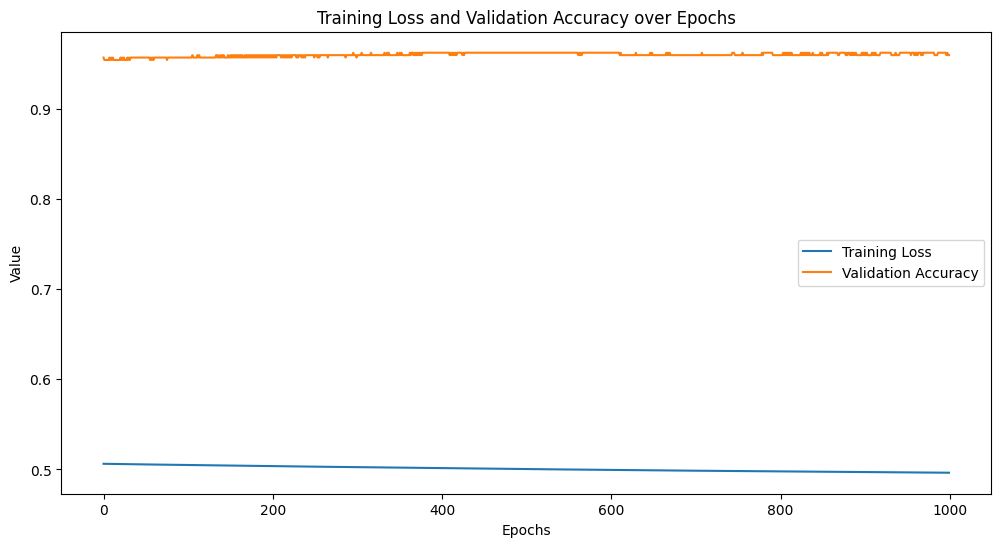

In [31]:
import matplotlib.pyplot as plt

# 修改訓練函數以記錄歷史數據
def train_model_with_logs(model, stock_inputs, sentiment_inputs, labels, val_stock, val_sentiments, val_labels, optimizer, criterion, epochs=1000):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # 訓練階段
        outputs = model(stock_inputs, sentiment_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 記錄訓練損失
        train_losses.append(loss.item())

        # 驗證階段
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_stock, val_sentiments)
            val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()
            val_true_labels = val_labels.cpu().numpy()
            val_accuracy = (val_preds == val_true_labels).mean()

        # 記錄驗證準確率
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_accuracies

# 訓練模型並記錄歷史數據
train_losses, val_accuracies = train_model_with_logs(
    fusion_model, train_stock, train_sentiments, train_labels,
    val_stock, val_sentiment, val_labels, optimizer, criterion
)

# 繪製曲線
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Loss and Validation Accuracy over Epochs")
plt.legend()
plt.show()
